# Real World P-Dispersion Problem

*Authors:* [Erin Olson](https://github.com/erinrolson), [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

In [43]:
import numpy
import geopandas
import pandas
import pulp
from shapely.geometry import Point
import matplotlib.pyplot as plt
import time

The problem is composed by 2 datafiles
- facility_points represents the stores that are candidate facility sites
- tract is the polygon of census tract 205.

Please note that all other 'Real World Facility Location' demonstration notebooks utilize [this file](https://github.com/huanfachen/Open_source_location_cover_models/blob/master/Data/San_Francisco_store/SF_network_distance_candidateStore_16_censusTract_205_new.csv) which contains facility to client network distances that were calculated using the ArcGIS Network Analyst Extension. This notebook, solving for P-Dispersion, *does not* use this file or any network distance values and instead relies on euclidean distance values for solving the model.

All datasets are available online in this [repository](https://github.com/huanfachen/Open_source_location_cover_models/tree/master/Data/San_Francisco_store)

In [44]:
DIRPATH = "../spopt/tests/data/"

facility_points = pandas.read_csv(DIRPATH + "SF_store_site_16_longlat.csv", index_col=0)
study_area = geopandas.read_file(DIRPATH + "ServiceAreas_4.shp").dissolve()

Display facility_points dataframe

In [45]:
display(facility_points)

,OBJECTID,NAME,long,lat
1,1,Store_1,-122.510018,37.772364
2,2,Store_2,-122.488873,37.753764
3,3,Store_3,-122.464927,37.774727
4,4,Store_4,-122.473945,37.743164
5,5,Store_5,-122.449291,37.731545
6,6,Store_6,-122.491745,37.649309
7,7,Store_7,-122.483182,37.701109
8,8,Store_11,-122.433782,37.655364
9,9,Store_12,-122.438982,37.719236
10,10,Store_13,-122.440218,37.745382


Plot tract

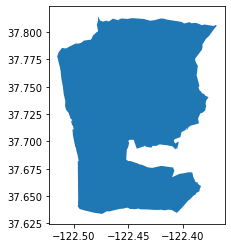

In [46]:
study_area.plot()

Create a geodataframe of the candidate facility sites.

In [47]:
facility_points_gdf = geopandas.GeoDataFrame(
    facility_points,geometry=geopandas.points_from_xy(
    facility_points.long, facility_points.lat))
facility_points_gdf

,OBJECTID,NAME,long,lat,geometry
1,1,Store_1,-122.510018,37.772364,POINT (-122.51002 37.77236)
2,2,Store_2,-122.488873,37.753764,POINT (-122.48887 37.75376)
3,3,Store_3,-122.464927,37.774727,POINT (-122.46493 37.77473)
4,4,Store_4,-122.473945,37.743164,POINT (-122.47395 37.74316)
5,5,Store_5,-122.449291,37.731545,POINT (-122.44929 37.73155)
6,6,Store_6,-122.491745,37.649309,POINT (-122.49175 37.64931)
7,7,Store_7,-122.483182,37.701109,POINT (-122.48318 37.70111)
8,8,Store_11,-122.433782,37.655364,POINT (-122.43378 37.65536)
9,9,Store_12,-122.438982,37.719236,POINT (-122.43898 37.71924)
10,10,Store_13,-122.440218,37.745382,POINT (-122.44022 37.74538)


The below method is used to plot the results of the solved P-Dispersion problems.

In [48]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

dv_colors = [
    "darkcyan",
    "mediumseagreen",
    "cyan",
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
] 

def plot_results(model, facility_points, title):
    fac_sites = []
    
    for i in range(len(facility_points)):
        if model.fac_vars[i].varValue == 1:
            fac_sites.append(i)
    sited_facilities = range(len(fac_sites))

    fig, ax = plt.subplots(figsize=(6, 6))
    legend_elements = []

    facility_points.plot(ax=ax, color='brown', marker="*", markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={len(facility_points)})'
    ))
    
    study_area.plot(ax=ax, alpha=.5, fc="tan", ec="k", zorder=1)
    _patch = Patch(alpha=.5, fc="tan", ec="k", label="Dissolved Service Areas")
    legend_elements.append(_patch)

    for i in sited_facilities:

        facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200 * 3.0,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor=dv_colors[i])
        
    for i in sited_facilities:
        legend_elements.append(mlines.Line2D(
        [],
        [],
        color=dv_colors[i],
        marker="*",
        ms=20 / 2,
        markeredgecolor="k",
        linewidth=0,
        alpha=0.8,
        label=f"y{fac_sites[i]} facility selected",
    ))

    plt.title(title, fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

## P-Dispersion

In [49]:
from spopt.locate import PDispersion

In [50]:
p=4

start_1 = time.time()
p_dispersion = PDispersion.from_geodataframe(facility_points_gdf, "geometry", p, distance_metric="euclidean")
end_1 = time.time()

time_spent_1 = end_1 - start_1

In [51]:
start_2 = time.time()
p_dispersion = p_dispersion.solve(pulp.PULP_CBC_CMD(msg=False, warmStart=True)) 
end_2 = time.time()

time_spent_2 = end_2 - start_2
total_time = time_spent_1 + time_spent_2

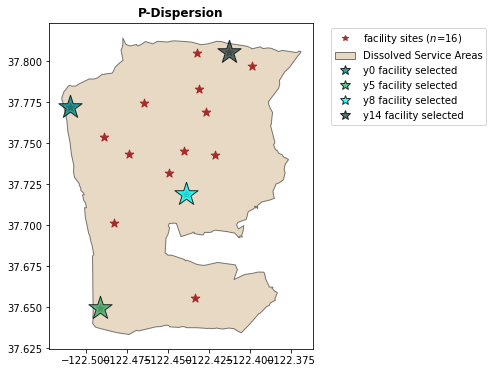

In [52]:
plot_results(p_dispersion, facility_points_gdf, "P-Dispersion")

## PDispersion San Francisco Case Study Results

In [53]:
print(f"San Francisco Dataset \nCandidate Facilities: 16    Number of Facilities Solved for: {p}   Computation Time: {total_time}")

San Francisco Dataset 
Candidate Facilities: 16    Number of Facilities Solved for: 4   Computation Time: 0.2192859649658203


In [54]:
facility_points_gdf['predefined_loc'] = numpy.array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0 ,0 ,0])
facility_points_gdf

,OBJECTID,NAME,long,lat,geometry,predefined_loc
1,1,Store_1,-122.510018,37.772364,POINT (-122.51002 37.77236),0
2,2,Store_2,-122.488873,37.753764,POINT (-122.48887 37.75376),0
3,3,Store_3,-122.464927,37.774727,POINT (-122.46493 37.77473),0
4,4,Store_4,-122.473945,37.743164,POINT (-122.47395 37.74316),1
5,5,Store_5,-122.449291,37.731545,POINT (-122.44929 37.73155),0
6,6,Store_6,-122.491745,37.649309,POINT (-122.49175 37.64931),0
7,7,Store_7,-122.483182,37.701109,POINT (-122.48318 37.70111),0
8,8,Store_11,-122.433782,37.655364,POINT (-122.43378 37.65536),1
9,9,Store_12,-122.438982,37.719236,POINT (-122.43898 37.71924),0
10,10,Store_13,-122.440218,37.745382,POINT (-122.44022 37.74538),0


In [55]:
p=6

start_1 = time.time()
p_dispersion = PDispersion.from_geodataframe(facility_points_gdf, "geometry", p, predefined_facility_col="predefined_loc", distance_metric="euclidean")
end_1 = time.time()

time_spent_1 = end_1 - start_1

In [56]:
start_2 = time.time()
p_dispersion = p_dispersion.solve(pulp.PULP_CBC_CMD(msg=False, warmStart=True)) 
end_2 = time.time()

time_spent_2 = end_2 - start_2
total_time = time_spent_1 + time_spent_2

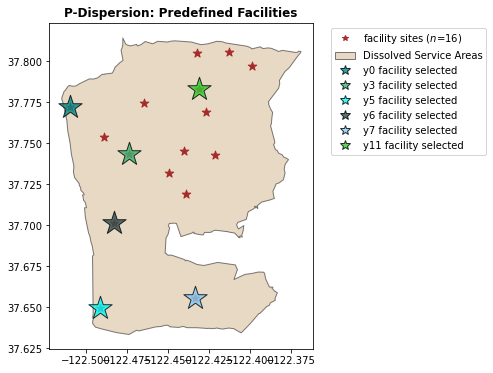

In [59]:
plot_results(p_dispersion, facility_points_gdf, "P-Dispersion: Predefined Facilities")

## PDispersion (predefined facility) San Francisco Case Study Results

In [58]:
print(f"San Francisco Dataset \nCandidate Facilities: 16    Number of Facilities Solved for: {p}   Computation Time: {total_time}")

San Francisco Dataset 
Candidate Facilities: 16    Number of Facilities Solved for: 6   Computation Time: 0.09120535850524902
